# Manejo de imagenes satelitales con Rasterio

Con anterioridad  en otro notebook se introdujo a la descarga de datos de sentinel usando *SentinelSat* en donde implementamos rasterio de forma basica para la  concatenación, visualización y recorte de una imagen sentinel. En este caso usaremos rasterio e iremos un paso mas alla en el proceso de analisis de imagenes. Como siempre em primer caso vamos a importar las librerias que usaremos mas adelante.

In [2]:
import rasterio as rio
from rasterio import plot
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterio.crs import CRS
from rasterio import mask
import numpy as np

Lo primero que vamos a hacer en este caso es definir una ruta donde esta la imagen que deseamos usar, en este caso usaremos la imagen que fue descargada previamente.

In [3]:
image = 'S2A_MSIL2A_20210113T152641_N0214_R025_T18NXL_20210113T172103/S2A_MSIL2A_20210113T152641_N0214_R025_T18NXL_20210113T172103.SAFE/GRANULE/L2A_T18NXL_A029051_20210113T153118/IMG_DATA/R10m'

Ahora vamos a abrir las bandas que son de nuestro interes,  lo haremos concatenando la ruta de la carpeta de la imagen mas el nombre de la banda. En este caso importamos las bandas 2(azul), 3(verde) y 4 y la banda 8A que corresponde a el infrarrojo cercano. En este caso usamos las imagenes con resolución de 10 metros

In [4]:
R10 = image
NIR = rio.open(R10+'/T18NXL_20210113T152641_B08_10m.jp2')
RED = rio.open(R10+'/T18NXL_20210113T152641_B04_10m.jp2')
GREEN = rio.open(R10+'/T18NXL_20210113T152641_B03_10m.jp2')
BLUE = rio.open(R10+'/T18NXL_20210113T152641_B02_10m.jp2')

Cargadas las capas de utilidad podemo iniciar por describir aspectos de las bandas de la imagen como alto y anchode esta, su sistema de referecia y sus limites. En este caso usaremos atributos de objeto b4 ( banda rojo).

In [4]:
print("El numero de filas  de la aimagen es {} y el numero de columnas es {}, el sistema de referencia es {}, la radiometria de la imagen es de {} y los limites de la imagen son{}".format(RED.height, RED.width, RED.crs, RED.dtypes, RED.bounds))

El numero de filas  de la aimagen es 10980 y el numero de columnas es 10980, el sistema de referencia es EPSG:32618, la radiometria de la imagen es de ('uint16',) y los limites de la imagen sonBoundingBox(left=600000.0, bottom=490200.0, right=709800.0, top=600000.0)


Ahora que accedimos a algunos de los atributos de la imagen, veamos las bandas de la imagen en tonalidades de color gris. En este caso

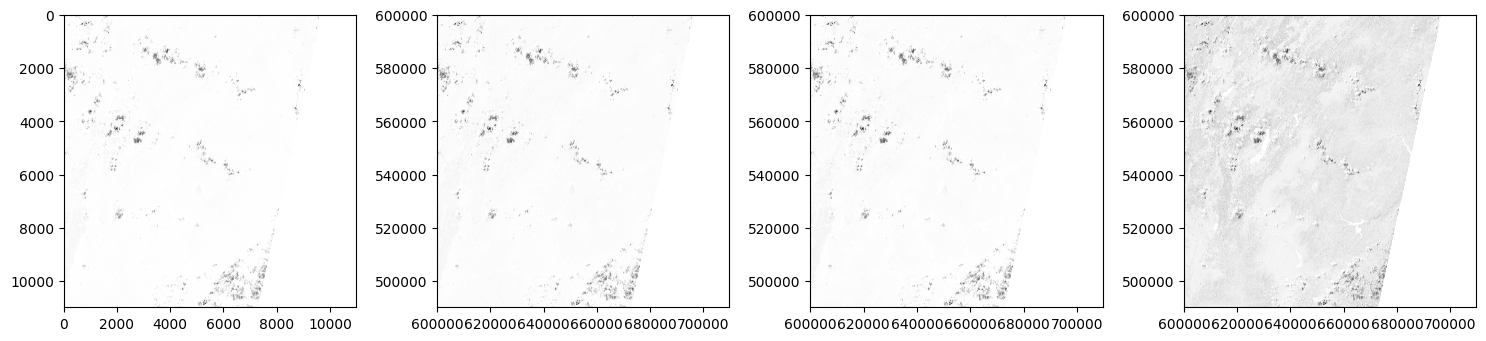

In [133]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(15,5))
plot.show(BLUE, ax=ax1, cmap='Greys')
plot.show(GREEN, ax=ax2, cmap='Greys')
plot.show(RED, ax=ax3, cmap='Greys')
plot.show(NIR, ax=ax4, cmap='Greys')
fig.tight_layout()

Como se puede ver las diferentes bandas en tono de color gris, no muestran mucha información en este caso se puede relacionar a el metodo de ajuste de *Rasterio.plot* el cual generalmente no se desempepeña bien cuando se trabaja con datos de mas de 8 bits. Lo siguiente que haremos sera crear una nueva imagen llamada *"S2A_16B.tiff"*. En esta usaremos para la definición del parametros de la banda *RED* y almacenaremos las bandas de la imagen BLUE, GREEN, RED y NIR en la posición 1 al 4 respectivamente. De igual forma definimos el parametro *count* igual a 4, el mismo numero de bandas.

In [6]:
# Create an RGB image 
with rio.open('S2A_16B.tiff','w',driver='Gtiff', width=RED.width, height=RED.height, 
              count=4, crs = CRS.from_epsg(32618) , transform=RED.transform, dtype=RED.dtypes[0]) as rgb:
    rgb.write(BLUE.read(1),1) 
    rgb.write(GREEN.read(1),2) 
    rgb.write(RED.read(1),3)
    rgb.write(NIR.read(1),4)
    rgb.close()

El siguiente paso es convertir la imagen a una resolución radiometrica de 8bits, para ello normalizaremos la imagen. Pero con anterioridad necesitamos crear los metadatos basicos de la imagen que sera creada, para ello cargaremos la imgen que acabamos de crear *SA2_16B.tiff* y haremos una copia de sus metadatos y posteriormente los actualizamos definiendo el nuevo numero de bandas y la escala radiometrica de la nueva imagen, de igual forma se define una nueva variable llamada *data* la cual almacenara un objeto *DatasetReader* con las cuatro bandas de la imagen; este lo usaremos para normalizar la imagen.

Por ultimo plotearemos la imagen me *SA2_16B.tiff*.

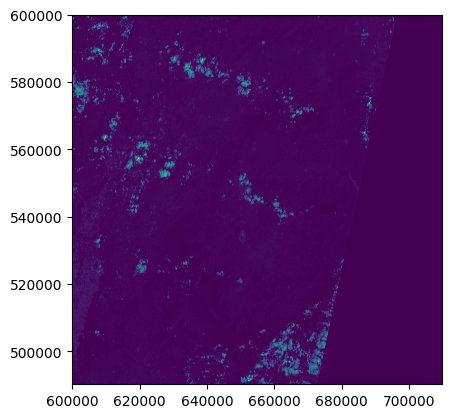

In [7]:
with rio.open('S2A_16B.tiff') as image16b:
    data = image16b.read([4, 3, 2,1])
    meta = image16b.meta
    plot.show(image16b)

meta2 = meta.copy()
meta2.update({'count':4,'dtype': 'uint8'})

Siguiendo vamos a definir una funcion llamada *normalizar*, la cual como parametros recibe una banda o listado de bandas, un limite superior e inferior. Eata funcion tomara los valores radiometricos minimo y maximo de cada banda, la diferencia entre el los limites superior e inferior definidosen la funcion, se divide entre la diferencia del valor radiometrico maximo y minimo de la imagen y esto define el parametro m (pendiente) que define la razon de cambio entre los los parametros de la nueva escala y la radiometria propia de cada imagen, este se usa para tranformar los valore de cada pixel a su nueva escala

In [10]:
def normalizar(band, lower, upper):
    band_min, band_max = band.min(), band.max()
    m = (upper - lower) / (band_max - band_min)
    return (m * (band - band_min)) + lower

Y ahora usamos la funcion para normalziar las bandas de la imagen, usado la funcion normalizar y un ciclo for que recorre cada una de las bandas en el parametro *data* que se definio de forma previa, vamos a instanciar una nueva variable img, la cual sera el resultado de hacer un proceso de stack a cada banda procesada, usando la libreria **Numpy**, en este caso el resultado del proceso es un objeto de tipo *numpy.ndarra*.

In [11]:
img = np.dstack([normalizar(band, 0, 255).astype("uint8") for band in data])

vamos a guardar la imagen normalizada. Como se menciono el resultado anterior es un array, generalmente cuando se trabaja con matrices en 3D en numpy el orden de este objeto es (*alto*,*ancho*,*numero de bandas*), pero cuando se trabaja con rasterio; como es nuestro caso que deseamos almacenar la imagen procesada. Se usa un objeto de typo *DatasetWriter* en el cual el orden de la matriz que usa el objeto para almacenar es (*numero de bandas*,*alto*,*ancho*) por lo cual para el almacenamiento es necesario mover los ejes del objeto usando la funcion [Numpy.moveaxis](https://numpy.org/doc/stable/reference/generated/numpy.moveaxis.html), en este caso almacenaremos la imagen con el nombre de *S2A_8B.tiff*.

In [12]:
with rio.open('S2A_8B.tiff', 'w', **meta2) as image8b:
    image8b.write(np.moveaxis(img, [0, 1, 2], [1, 2, 0]))
    image8b.close()

Veamos la *S2A_8B.tiff* usando la funcion plot.show de rasterio.

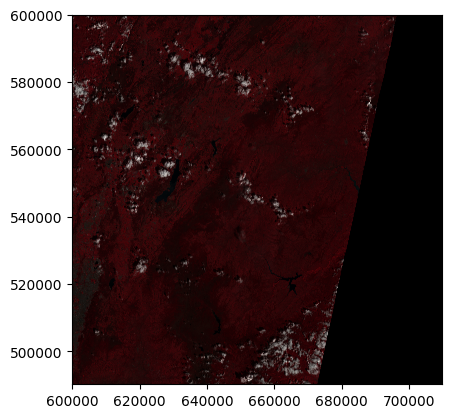

In [131]:
S2A_8B = rio.open("S2A_8B.tiff")
plot.show(S2A_8B)
S2A_8B.close()

Con las imagen convertida a una radiometrida de 8bits, recortaremos la zona de interes. Para ello primero hacemos un filtrado sobre el archivo shapefile de municipios de colombia, despues de seleccionar le municipio que en este caso el Gachala, ubicado en Cundinamarca, vamos a  tranformar esta entodad geografica al mismo sistema coordenado de la imagen que es *WGS84 UTM ZONE 18N*.

In [40]:
Municipios = gpd.read_file('Datos/MGN_MPIO_POLITICO.shp')
Gachala = Municipios[(Municipios.DPTO_CNMBR =='CUNDINAMARCA') & (Municipios.MPIO_CNMBR == 'GACHALÁ')]
gachala_proj = Gachala.to_crs("epsg:32618")

Ahora usando una mascara definida por la entidad geografica del municipio seleccionado, recortaremos la imagen *S2A_8B.tiff* y la vamos a guardar con el nombre de imagenSalida. En este proceso es necesario modificar la metadata de la imagen de salida, indicando el nuevo numero de filas, columnas, tranformacion y driver de la imagen recortada.

In [180]:
with rio.open("S2A_8B.tiff") as image8b:
    imagenSalida, transfSalida = rio.mask.mask(image8b, gachala_proj.geometry,crop=True)
    out_meta = image8b.meta.copy()
    out_meta.update({"driver": "GTiff",
                 "height": imagenSalida.shape[1],
                 "width": imagenSalida.shape[2],
                 "transform": transfSalida})
    

Guardamos el recorte de la imagen con el nombre de *ZonaInteres.tiff* y como parametros definimos todos los metadatos de la imagen usando los metadatos definidos previamente.

In [184]:
with rio.open("ZonaInteres.tiff", "w", **out_meta) as dest:
    dest.write(imagenSalida)

Veamos el recorte de la imagen usando la zona de interes del municipio de Gachala, para ello leermos la imagen gurdada previamente intanciando con esta a la varaible *GachalaRaster* que no es nada mas que ub objeto *DatasetReader* que contiene a la imagen recortada.

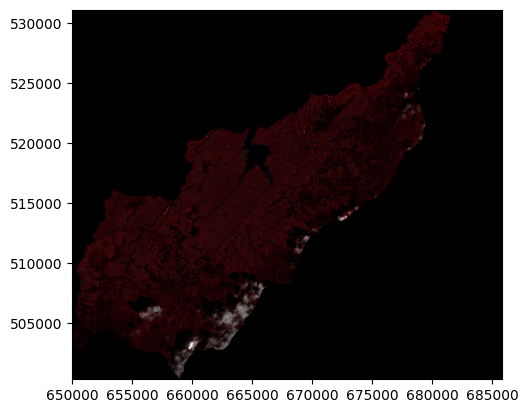

<AxesSubplot: >

In [41]:
GachalaRaster = rio.open("ZonaInteres.tiff")
plot.show(GachalaRaster)

La imagen resultado se muestra en lo que se conoce como falso color estandar que es la conbinación de las bandas (nir, red y blue) en los cañones del rojo, verdes y azul respectivamente. Como se las zonas con vegetación se muestra en tonos de rojo, mientras que las zona sin datos o con superfciles e agia se ven en negro.

Recortada la imagen, vamos a realizar unas operaciones basicas para el calculo de tres indices *NDVI*, *SAVI* y *NDWI*, los dos primeros usaods para la identifiación la presencia de material vegetal sobre el territorio y el ultimo para la identificación de cuerpos de agua. Para ello usando la varaible definida previamente leeremos las bandas de interes como un objeto array de tipo *'uint8'*, y guardaremos tres variables llamadas *nir, red* y *green* que seran usadas para el calculo de los indices. Las formulas anteriores se muestran en *Lillesand et al; 2015*

<img src="imagenes/FormulaNDVI.png" />
<img src="imagenes/FormulaSAVI.png">

En el caso del indice NDWi se usa la formula definida por *Mcfeeters, (1996)* que define este  como  NDWI = (Bgreen - Bnir)/(Bgreen + Bnir).

In [16]:
nir = np.array(GachalaRaster.read(4),GachalaRaster.read(4).dtype)
red = np.array(GachalaRaster.read(3),GachalaRaster.read(3).dtype)
green = np.array(GachalaRaster.read(2),GachalaRaster.read(2).dtype)
GachalaRaster.close()

Despues de definir las bandas aplicamos las debidas formulas de los indices 

In [19]:
NDVI = (nir.astype('float64') - red.astype('float64')) / (nir.astype('float64') + red.astype('float64'))
NDWI = (green.astype('float64') - nir.astype('float64')) / (nir.astype('float64') + green.astype('float64'))
SAVI = ((nir.astype('float64') - red.astype('float64')) / (nir.astype('float64') + red.astype('float64')+ 0.5))*(1+0.5)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13024\2555373548.py:1: RuntimeWarning: invalid value encountered in divide
  NDVI = (nir.astype('float64') - red.astype('float64')) / (nir.astype('float64') + red.astype('float64'))
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13024\2555373548.py:2: RuntimeWarning: invalid value encountered in divide
  NDWI = (green.astype('float64') - nir.astype('float64')) / (nir.astype('float64') + green.astype('float64'))


Ahora se veamos los resultados de los indices usando las funciones de *rasterio* y la libreria de *matplotlib*

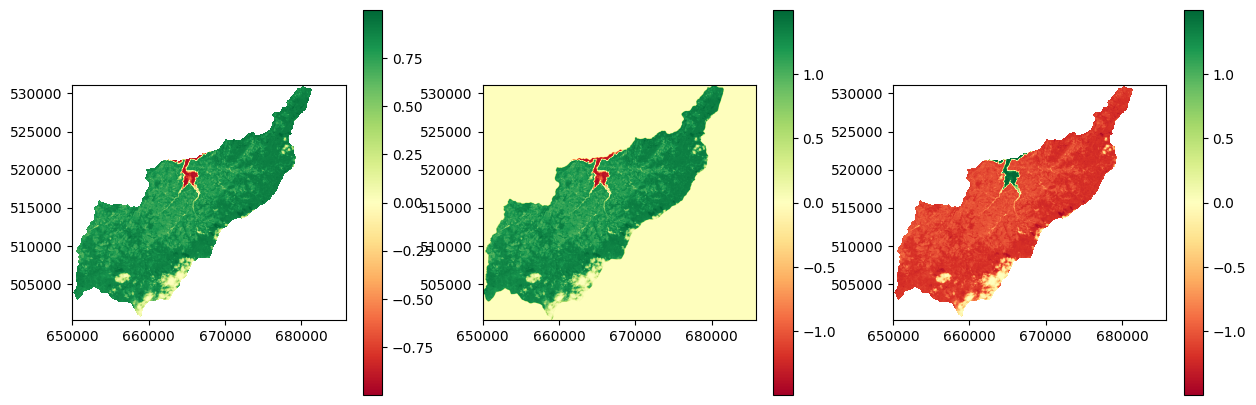

In [150]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))

# use imshow so that we have something to map the colorbar to
image_hidden = ax1.imshow(NDVI,cmap="RdYlGn")
image_hidden1 = ax2.imshow(SAVI,cmap="RdYlGn")
image_hidden2 = ax3.imshow(SAVI,cmap="RdYlGn")


# plot on the same axis with rio.plot.show
image = rio.plot.show(NDVI, 
                      transform=GachalaRaster.transform, 
                      ax=ax1, 
                      cmap="RdYlGn")

image = rio.plot.show(SAVI, 
                      transform=GachalaRaster.transform, 
                      ax=ax2, 
                      cmap="RdYlGn")

image = rio.plot.show(NDWI, 
                      transform=GachalaRaster.transform, 
                      ax=ax3, 
                      cmap="RdYlGn")

# add colorbar using the now hidden image
fig.colorbar(image_hidden, ax=ax1,)
fig.colorbar(image_hidden1, ax=ax2)
fig.colorbar(image_hidden1, ax=ax3)

El primer grafico a la derecha representa la imagen resultado del indice NDVI, a la derecha el indice SAVI, y seguido el indice NDWI. Como se aprecia en el primero y el segundo los valores relaacionados a las coberturas vegetales se mapean en tonos verdes asociados a valores de NDVI superiores a 0.7, entre mas fuerte sea el tono de color mayor es la biomasa vegetal, como se puede ver en la zona donde hay presencia de cuerpos acuaticos se presentan tonos rojos asocidos a valores de NDVI negativos. Para el caso del tercer indice las respuestas espectrales son inversas, las zonas con presencia de biomasa vegetal se muestran en tonos rojos asociados a valores bajos o negativos, mientras que las zonas en las cuales se presentan tonalidades verdes asociadas a valores positivos mayores que 0.7 se muestran aquellas zonas con aguas continentales, como es el caso d eparte del embalse del Guavio.

### Conclusiones
- La libreria rasterio dispone de funciones suficientes para llevar a cabo procesos de manejo y procesamiento de imagenes, la cual puede facilitar el trabajo con datos geograficos, cuando no se disponene del uso de SIG.
- El uso de python para la utomatización de información permite llevar a acabo labores sobre archivos geograficos de forma optima y rapida.


### Referencias

- S. K. McFEETERS (1996) The use of the Normalized Difference Water Index (NDWI) in the delineation of open water features, International Journal of Remote Sensing, 17:7, 1425-1432, DOI: 10.1080/01431169608948714
- Lillesand, T., Kiefer, R. W. & Chipman, J. (2015). Remote Sensing and Image Interpretation (7th Revised ed.). Wiley.